In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from core.core import * 
from util.detector import * 
from util.estimator import * 
from util.modem import * 

In [3]:
def ml(y_re, H_re, symbol_space, snr_dB):
    """
    Maximum Likelihood detection for KxN mu-MIMO channel (uses Gaussian distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
    likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_ML = x_hat_ML.reshape(x_shape)
    return x_hat_ML 

def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init


# 1. Maximum Likelihood Detection for 1-bit ADC 

In [15]:
trials = 10
K = 2; N = 16; T = 10000; M = 4

snr_min = -10 
snr_max = 30 
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), )) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)

for t in range(trials):
    print(f"Trial #{t}: ", end=' ')
    sers = []
    for snr in snr_lst:
        # print(f"snr {snr}...", end=' ')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        x_hat_ML = ml(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)

        ser_ml = np.sum(1 - np.isclose(x_hat_ML, x)) / (T * K)
        sers.append(ser_ml)

    sers = np.array(sers)
    print(sers)
    print(sers_avg)
    sers_avg += sers     

sers_avg /= trials
print(sers_avg)

Trial #0:  

/var/folders/qf/g6m74fsx51j_2q1__9zjd_5m0000gn/T/ipykernel_11336/138658605.py:13: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihood), axis=2)


[3.1395e-01 1.0750e-01 1.4650e-02 1.3500e-03 5.0000e-05 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Trial #1:  [3.162e-01 1.075e-01 1.265e-02 7.500e-04 1.000e-04 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[3.1395e-01 1.0750e-01 1.4650e-02 1.3500e-03 5.0000e-05 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
Trial #2:  [3.117e-01 1.110e-01 1.235e-02 1.000e-03 5.000e-05 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[6.3015e-01 2.1500e-01 2.7300e-02 2.1000e-03 1.5000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
Trial #3:  [3.1500e-01 1.0985e-01 1.3650e-02 9.5000e-04 1.0000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
[9.4185e-01 3.2600e-01 3.9650e-02 3.1000e-03 2.0000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
Trial #4:  [0.31615 0.1056  0.01345 0.0011  0.      0.      0.      0.      0.     ]
[1.25685e+00 4.35850e-01 5.33000e-02 4.05000e-03 3.00000e-04 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]
Trial #5:  [3.1785e-01 1.0585e-01 1.3100e-02 1

# 2. Robust ML detection for robust 1-bit ADC 

In [87]:
def sigmoid(t, c=1.702):
    return (1 / (1 + np.exp(-1 * c * t)))

def robust_ml(y_re, H_re, symbol_space, snr_dB):
    """
    robust Maximum Likelihood detection for KxN mu-MIMO channel (uses sigmoid instead of Normal Distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)   # convert dB scale to normal scale 

    # get informations from the channel matrix 
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])

    # real representation of symbol_space 
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))

    # Compute the Log-likelihood 
    likelihood = sigmoid(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)

    # pick symbol from the symbol space which maximizes the Likelihood 
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_rML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_rML = x_hat_rML.reshape(x_shape)
    return x_hat_rML 

In [98]:
trials = 100
K = 2; N = 16; T = 100000; M = 4

snr_min = -10 
snr_max = 30 
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), 2)) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)

for t in range(trials):
    print("Trial", t, "...", end=' ')
    sers = []
    for snr in snr_lst:
        # print(f"snr {snr}...", end=' ')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        x_hat_ML = ml(y_re, H_re, symbol_space, snr)
        x_hat_rML = robust_ml(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)
        ser_ml = np.sum(1 - np.isclose(x_hat_ML, x)) / (T * K)
        ser_rml = np.sum(1 - np.isclose(x_hat_rML, x)) / (T * K)
        # print(ser_rml)
        sers.append([ser_ml, ser_rml])
    sers = np.array(sers)
    print(sers[:, 0])

    sers_avg += sers     

sers_avg /= trials
# print(f"{sers_avg[:, 0]}")
# print(f"{sers_avg[:, 1]}")



Trial 0 ... 

/var/folders/qf/g6m74fsx51j_2q1__9zjd_5m0000gn/T/ipykernel_11336/138658605.py:13: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihood), axis=2)


[3.16645e-01 1.07435e-01 1.39950e-02 8.20000e-04 3.50000e-05 1.00000e-05
 0.00000e+00 5.00000e-06 0.00000e+00]
Trial 1 ... 

KeyboardInterrupt: 

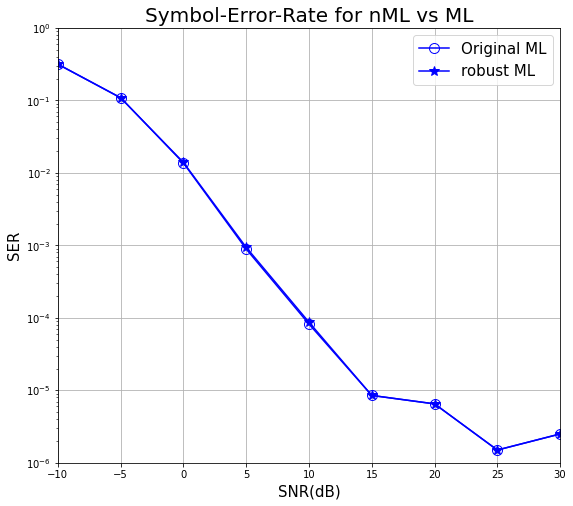

In [95]:
plt.figure(figsize=(9, 8))
# plt.semilogy(snr_lst[1:], results[2], '-s', )
plt.semilogy(snr_lst, sers_avg[:, 0], '-bo', markersize=10, label='Original ML', fillstyle='none')
plt.semilogy(snr_lst, sers_avg[:, 1], '-b*', markersize=10, label='robust ML')
plt.xlim([-10, 30]); plt.ylim([1e-6, 1e0])
plt.xlabel("SNR(dB)", fontsize=15); plt.ylabel("SER", fontsize=15); plt.title("Symbol-Error-Rate for nML vs ML", fontsize=20)
plt.grid(); plt.legend(fontsize=15)
plt.show()